In [68]:
import math
import os
import warnings
from glob import glob
from itertools import cycle
import re

import matplotlib.pyplot as plt
plt.style.use("grayscale")

import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')

In [69]:
def rounddown(x):
     return int(math.ceil(x / 100.0)) * 100 - 100

def removed_outliers(df, column, level=3):
    return df[((df[column] - df[column].mean()) / df[column].std()).abs() < level]

In [70]:
def smoothen_plot(x, y, smooth_power=300):
    smoothened_x = np.linspace(x.min(), x.max(), smooth_power)
    spl = make_interp_spline(x, y, k=3)
    smoothened_y = spl(smoothened_x)
    return smoothened_x, smoothened_y

In [71]:
def create_plot_ac_u_comp(df, cumulative=False, plot_title="", clean=3, smooth_u=0, smooth_ac=0, draw_v_lines=False):
    if clean:
        cleaned_df = removed_outliers(df, 'ac_iter_time', level=clean)
        cleaned_df = removed_outliers(cleaned_df, 'norm_iter_time', level=clean)
        cleaned_df.reset_index(drop=True, inplace=True)
    else:
        cleaned_df = df

    fig, ax = plt.subplots(figsize=(15, 5))
    if plot_title:
        ax.set_title(plot_title)

    ax.set_xlabel('Iteration')
    if cumulative:
        ax.set_ylabel('Elapsed time [s]')
        cleaned_df.ac_iter_time = cleaned_df.ac_iter_time / (10 ** 9)
        cleaned_df.norm_iter_time = cleaned_df.norm_iter_time / (10 ** 9)
    else:
        ax.set_ylabel('Time of 10 iterations [ms]')
        cleaned_df.ac_iter_time = cleaned_df.ac_iter_time / (10 ** 6)
        cleaned_df.norm_iter_time = cleaned_df.norm_iter_time / (10 ** 6)

    if smooth_ac:
        new_iter_no, ac_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.ac_iter_time, smooth_ac)
    else:
        new_iter_no, ac_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.ac_iter_time

    ax.plot(new_iter_no, ac_iter_time_smooth, label='Active cells', c='black', ls='-.')

    if smooth_u:
        new_iter_no, norm_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.norm_iter_time, smooth_u)
    else:
        new_iter_no, norm_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.norm_iter_time

    ax.plot(new_iter_no, norm_iter_time_smooth, label='Non-active cells', c='black', ls=':')

    iteration_no = cleaned_df['iteration_no']

    cross_point = ((cleaned_df['ac_iter_time'] - cleaned_df['norm_iter_time']).abs()).idxmin()
    if draw_v_lines:
        ax.axvline(x=iteration_no[cross_point], lw=1, ls='--', c='black')
        y_lim = ax.get_ylim()
        x_lim = ax.get_xlim()
        ax.text(iteration_no[cross_point] - x_lim[1] * .01,
                (y_lim[1] - y_lim[0]) * .02 + y_lim[0],
                'Iteration time crossover', rotation=90)

    xs = (
      list(range(0, cleaned_df.shape[0], round(cleaned_df.shape[0] / 6)))
      + [cross_point, len(cleaned_df) - 1]
    )
    xticks = [iteration_no[i]  for i in xs]


    ax.set_xticks([rounddown(i) for i in xticks])

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Fraction of active cells in CA')

    secax.set_xticks(xticks)
    secax.set_xticklabels([
        f'{cleaned_df[cleaned_df.iteration_no == i].ac_coverage.iloc[0] * 100:.0f}%'
        for i in xticks
    ])

    plt.legend()
    return fig


In [72]:
def read_ca_size_data(dir_path = "results/paper/ca_size/", test_name="standard"):
    df = pd.DataFrame()
    df["ca_size"] = range(1000,9000,1000)

    files = sorted(glob(f"{dir_path}/{test_name}/*{1000}*"))
    for j,file in enumerate(files):
        params_match = re.search(r"\d", file)
        file_name = os.path.basename(file[:params_match.start()])
        file_name = file_name.replace("coverage_","")
        file_data=[]
        for i, ca_size in enumerate(df.ca_size):
            files = glob(f"{dir_path}/{test_name}/*{file_name}*{ca_size}*")
            file_df = pd.read_csv(files[0], skiprows=2, names=["ac_coverage",'iter_time', 'z', 'x', 'y'])
            file_data.append(file_df["iter_time"].cumsum().iloc[-1] / 10**9)
        df[file_name]=file_data

    return df

In [73]:
def create_ca_size_plot(df, clean=3 ):
    fig, ax = plt.subplots(figsize=(10, 5))

    if clean != -1:
        for test in df:
            df = removed_outliers(df, test, level=clean)
            df.reset_index(drop=True, inplace=True)

    ca_size = df['ca_size']
    df.drop(['ca_size'], axis=1, inplace=True)

    ax.set_xlabel('CA dimension')
    ax.set_ylabel('Elapsed time [s]')

    line_styles = cycle([":", "--", "-.", "-"])
    marker_styles = cycle(("o", "x", "*", "+", "D", "X", ".", "s"))
    for file_name in df:
        ax.plot(ca_size,
                df[file_name],
                linestyle=next(line_styles),
                marker=next(marker_styles),
                label=file_name.replace("_", " ").title(),
                )

    plt.legend()
    return fig

In [74]:
if not os.path.isdir("charts"):
    os.makedirs("charts")

## Paper

### Paper Standard ca size test

['results/paper/ca_size//standard/coverage_u_hybrid_1000_4500_2_0_1.csv', 'results/paper/ca_size//standard/coverage_u_shared_1000_4500_2_0_1.csv', 'results/paper/ca_size//standard/coverage_u_standard_1000_4500_2_0_1.csv']


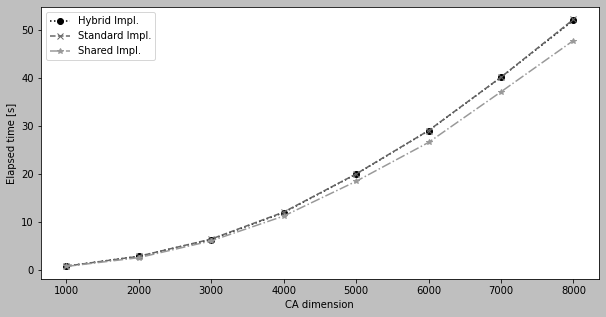

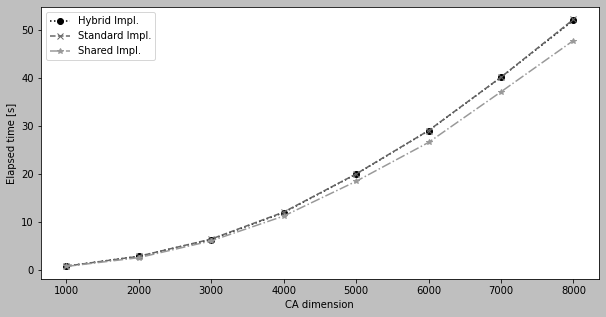

In [75]:
df=read_ca_size_data()
df = df.rename(columns={
     "u_hybrid_": "Hybrid impl.",
     "u_standard_": "Shared impl.",
     "u_shared_": "Standard impl.",
})
create_ca_size_plot(df)
#plt.savefig("charts/paper/standard.pdf")

### Paper Standard ca size test STRESS

['results/paper/ca_size//standard_stress/coverage_u_hybrid_stress_1000_4500_2_0_1.csv', 'results/paper/ca_size//standard_stress/coverage_u_shared_stress_1000_4500_2_0_1.csv', 'results/paper/ca_size//standard_stress/coverage_u_standard_stress_1000_4500_2_0_1.csv']


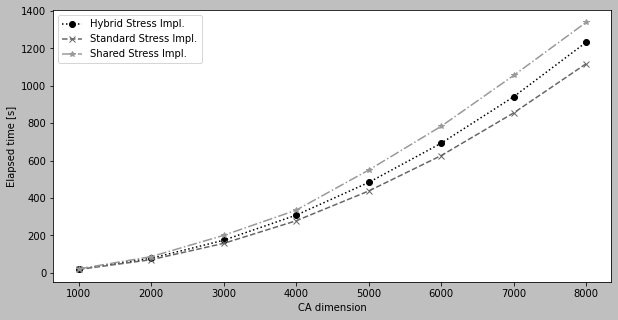

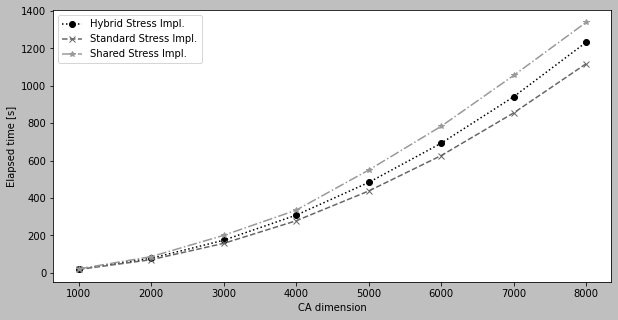

In [76]:
df=read_ca_size_data(test_name="standard_stress")
df = df.rename(columns={
     "u_hybrid_stress_": "Hybrid stress impl.",
     "u_standard_stress_": "Shared stress impl.",
     "u_shared_stress_": "Standard stress impl.",
})
create_ca_size_plot(df)
#plt.savefig("charts/paper/standard_stress.pdf")

### Paper Active Cells ca size test STRESS

['results/paper/ca_size//active_cells/coverage_ac_u_naive_1000_4500_2_0_1.csv', 'results/paper/ca_size//active_cells/coverage_ac_u_sc_1000_4500_2_0_1.csv', 'results/paper/ca_size//active_cells/coverage_ac_u_sc_fk_1000_4500_2_0_1.csv', 'results/paper/ca_size//active_cells/coverage_ac_u_sc_one_kernel_adaptive_1000_4500_2_0_1.csv', 'results/paper/ca_size//active_cells/coverage_u_standard_1000_4500_2_0_1.csv']


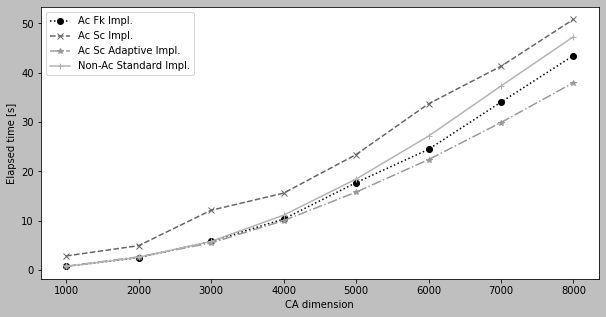

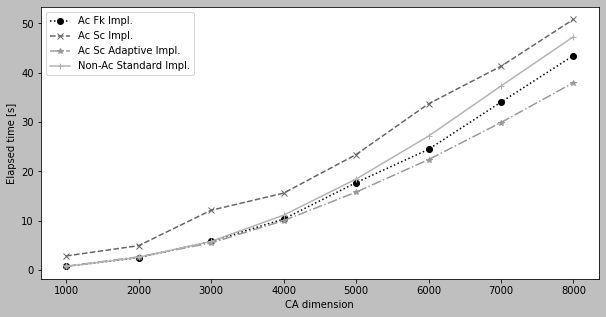

In [77]:
df=read_ca_size_data(test_name="active_cells")
df.drop("ac_u_sc_", axis=1, inplace=True)
df = df.rename(columns={
     "ac_u_naive_": "AC FK impl.",
     "ac_u_sc_one_kernel_adaptive_": "AC SC adaptive impl.",
     "ac_u_sc_fk_": "AC SC impl.",
     "u_standard_": "Non-AC standard impl.",
})
create_ca_size_plot(df)
#plt.savefig("charts/paper/active_cells_ca_size.pdf")

### Paper Active Cells ca size test STRESS

['results/paper/ca_size//active_cells_stress/coverage_ac_u_naive_stress_1000_4500_2_0_1.csv', 'results/paper/ca_size//active_cells_stress/coverage_ac_u_sc_one_kernel_adaptive_stress_1000_4500_2_0_1.csv', 'results/paper/ca_size//active_cells_stress/coverage_ac_u_sc_one_kernel_stress_1000_4500_2_0_1.csv', 'results/paper/ca_size//active_cells_stress/coverage_ac_u_sc_stress_1000_4500_2_0_1.csv', 'results/paper/ca_size//active_cells_stress/coverage_u_standard_stress_1000_4500_2_0_1.csv']


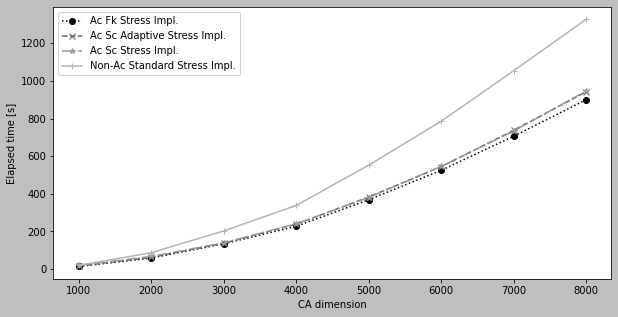

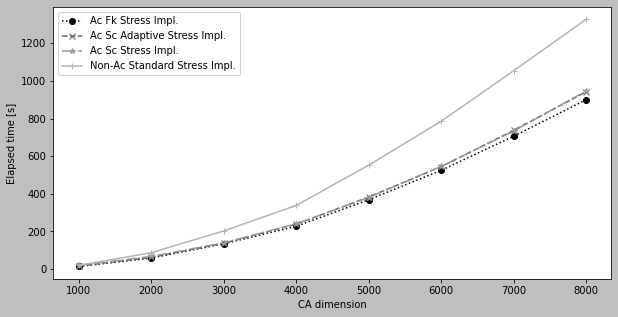

In [78]:

df=read_ca_size_data(test_name="active_cells_stress")
df.drop("ac_u_sc_stress_", axis=1, inplace=True)

df = df.rename(columns={
     "ac_u_naive_stress_": "AC FK stress impl.",
     "ac_u_sc_one_kernel_adaptive_stress_": "AC SC adaptive stress impl.",
     "ac_u_sc_one_kernel_stress_": "AC SC stress impl.",
     "u_standard_stress_": "Non-AC standard stress impl.",
})

create_ca_size_plot(df)
#plt.savefig("charts/paper/active_cells_ca_size_stress.pdf")

## Thesis Paszczak

In [79]:
if not os.path.isdir("charts"):
    os.makedirs("charts")
if not os.path.isdir("charts/paszczak"):
    os.makedirs("charts/paszczak")

### Paszczak Standard ca size test

['results/mount/paszczak/ca_size//standard/coverage_u_hybrid_1000_4500_2_0_1.csv', 'results/mount/paszczak/ca_size//standard/coverage_u_shared_1000_4500_2_0_1.csv', 'results/mount/paszczak/ca_size//standard/coverage_u_standard_1000_4500_2_0_1.csv']


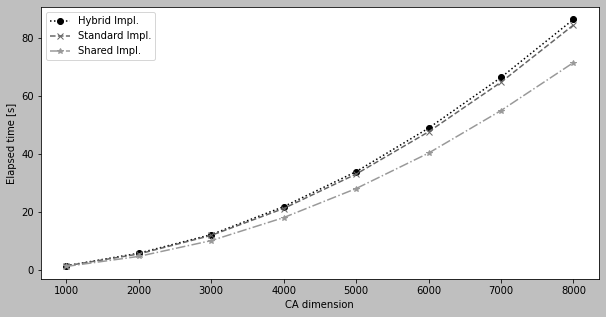

In [80]:
df=read_ca_size_data(dir_path = "results/mount/paszczak/ca_size/")
df = df.rename(columns={
     "u_hybrid_": "Hybrid impl.",
     "u_standard_": "Shared impl.",
     "u_shared_": "Standard impl.",
})
create_ca_size_plot(df)
plt.savefig("charts/paszczak/standard.pdf")

### Paszczak Standard ca size test STRESS

['results/mount/paszczak/ca_size//standard_stress/coverage_u_standard_stress_1000_4500_2_0_1.csv']


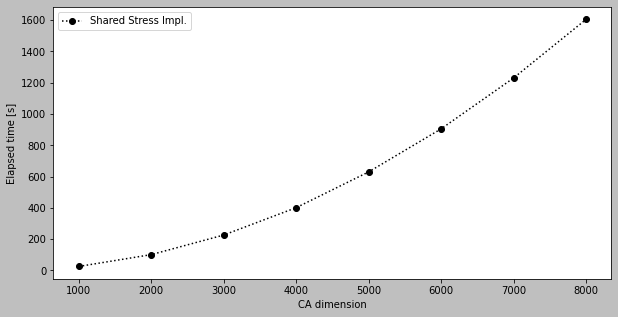

In [81]:
df=read_ca_size_data(dir_path = "results/mount/paszczak/ca_size/", test_name="standard_stress")
df = df.rename(columns={
     "u_hybrid_stress_": "Hybrid stress impl.",
     "u_standard_stress_": "Shared stress impl.",
     "u_shared_stress_": "Standard stress impl.",
})
create_ca_size_plot(df)
plt.savefig("charts/paszczak/standard_stress.pdf")

### Paszczak Active cells ca size test

['results/mount/paszczak/ca_size//active_cells/coverage_ac_u_fk_1000_4500_2_0_1.csv', 'results/mount/paszczak/ca_size//active_cells/coverage_ac_u_sc_1000_4500_2_0_1.csv', 'results/mount/paszczak/ca_size//active_cells/coverage_ac_u_sc_adaptive_1000_4500_2_0_1.csv', 'results/mount/paszczak/ca_size//active_cells/coverage_u_standard_1000_4500_2_0_1.csv']


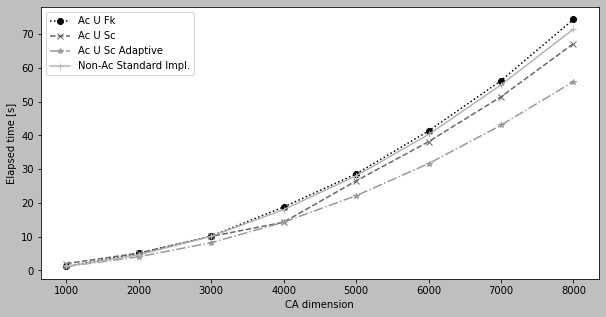

In [82]:
df=read_ca_size_data(dir_path = "results/mount/paszczak/ca_size/", test_name="active_cells")
df = df.rename(columns={
     "ac_u_naive_": "AC FK impl.",
     "ac_u_sc_one_kernel_adaptive_": "AC SC adaptive impl.",
     "ac_u_sc_fk_": "AC SC impl.",
     "u_standard_": "Non-AC standard impl.",
})

create_ca_size_plot(df)
plt.savefig("charts/active_cells_ca_size.pdf")

### Paszczak Active cells ca size test STRESS

In [83]:
df=read_ca_size_data(dir_path = "results/mount/paszczak/ca_size/", test_name="active_cells_stress")
df.drop("ac_u_sc_stress_", axis=1, inplace=True)

df = df.rename(columns={
     "ac_u_naive_stress_": "AC FK stress impl.",
     "ac_u_sc_one_kernel_adaptive_stress_": "AC SC adaptive stress impl.",
     "ac_u_sc_one_kernel_stress_": "AC SC stress impl.",
     "u_standard_stress_": "Non-AC standard stress impl.",
})

create_ca_size_plot(df)
plt.savefig("charts/active_cells_ca_size_stress.pdf")

['results/mount/paszczak/ca_size//active_cells_stress/coverage_ac_u_fk_stress_1000_4500_2_0_1.csv', 'results/mount/paszczak/ca_size//active_cells_stress/coverage_ac_u_sc_adaptive_stress_1000_4500_2_0_1.csv', 'results/mount/paszczak/ca_size//active_cells_stress/coverage_ac_u_sc_stress_1000_4500_2_0_1.csv', 'results/mount/paszczak/ca_size//active_cells_stress/coverage_u_standard_stress_1000_4500_2_0_1.csv']


IndexError: list index out of range

## Thesis Conway

In [84]:
if not os.path.isdir("charts"):
    os.makedirs("charts")
if not os.path.isdir("charts/conway"):
    os.makedirs("charts/conway")

### Conway Standard ca size test

['results/mount/conway/ca_size/standard/coverage_u_hybrid_1000_4500_2_0_1.csv', 'results/mount/conway/ca_size/standard/coverage_u_shared_1000_4500_2_0_1.csv', 'results/mount/conway/ca_size/standard/coverage_u_standard_1000_4500_2_0_1.csv']


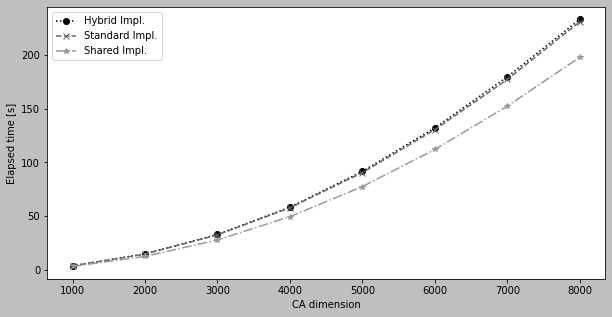

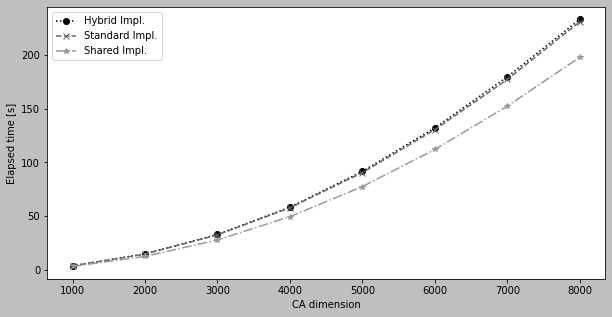

In [85]:
df=read_ca_size_data(dir_path = "results/mount/conway/ca_size")
df = df.rename(columns={
     "u_hybrid_": "Hybrid impl.",
     "u_standard_": "Shared impl.",
     "u_shared_": "Standard impl.",
})
create_ca_size_plot(df)
plt.savefig("charts/conway/standard.pdf")

### Conway Standard ca size test STRESS

In [86]:
df=read_ca_size_data(dir_path = "results/mount/conway/ca_size/", test_name="standard_stress")
df = df.rename(columns={
     "u_hybrid_stress_": "Hybrid stress impl.",
     "u_standard_stress_": "Shared stress impl.",
     "u_shared_stress_": "Standard stress impl.",
})
create_ca_size_plot(df)
plt.savefig("charts/conway/standard_stress.pdf")

['results/mount/conway/ca_size//standard_stress/coverage_u_standard_stress_1000_4500_2_0_1.csv']


IndexError: list index out of range

### Conway Active cells ca size test

['results/mount/conway/ca_size//active_cells/coverage_ac_u_fk_1000_4500_2_0_1.csv', 'results/mount/conway/ca_size//active_cells/coverage_ac_u_sc_1000_4500_2_0_1.csv', 'results/mount/conway/ca_size//active_cells/coverage_ac_u_sc_adaptive_1000_4500_2_0_1.csv', 'results/mount/conway/ca_size//active_cells/coverage_u_standard_1000_4500_2_0_1.csv']


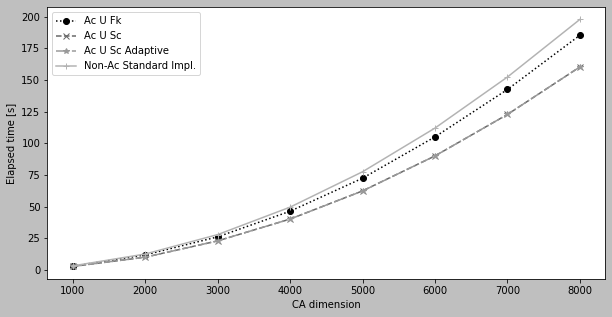

In [88]:
df=read_ca_size_data(dir_path = "results/mount/conway/ca_size", test_name="active_cells")
df = df.rename(columns={
     "ac_u_naive_": "AC FK impl.",
     "ac_u_sc_one_kernel_adaptive_": "AC SC adaptive impl.",
     "ac_u_sc_fk_": "AC SC impl.",
     "u_standard_": "Non-AC standard impl.",
})

create_ca_size_plot(df)
plt.savefig("charts/conway/active_cells_ca_size.pdf")

### Conway Active cells ca size test STRESS

In [ ]:
df=read_ca_size_data(dir_path = "results/mount/conway/ca_size/", test_name="active_cells_stress")
df.drop("ac_u_sc_stress_", axis=1, inplace=True)

df = df.rename(columns={
     "ac_u_naive_stress_": "AC FK stress impl.",
     "ac_u_sc_one_kernel_adaptive_stress_": "AC SC adaptive stress impl.",
     "ac_u_sc_one_kernel_stress_": "AC SC stress impl.",
     "u_standard_stress_": "Non-AC standard stress impl.",
})

create_ca_size_plot(df)
plt.savefig("charts/active_cells_ca_size_stress.pdf")


